<a href="https://colab.research.google.com/github/vpaliwal1/CIFAR10-Image-classification-with-PyTorch/blob/master/Cifar10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

In [0]:
!pip3 install pillow==4.0.0

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testing_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size = 100, shuffle=False)

0it [00:00, ?it/s]

170500096it [00:06, 26819529.41it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

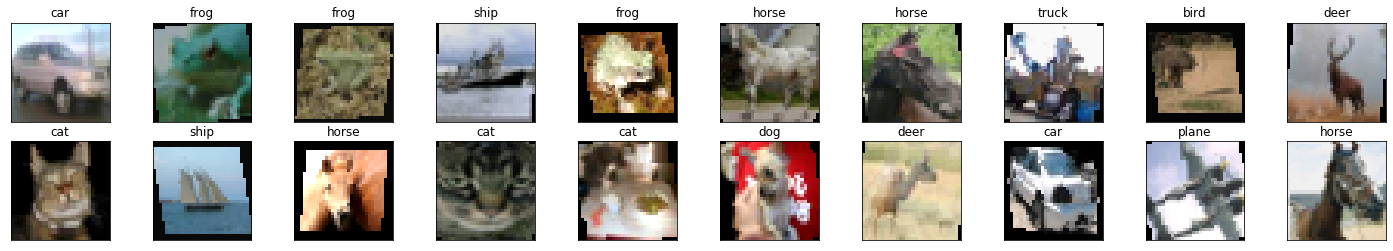

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [0]:
epochs = 10
running_loss_hist = []
running_corrects_hist = []
test_running_loss_hist = []
test_running_corrects_hist= []

for r in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs,1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for test_inputs, test_labels in testing_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_preds = torch.max(test_outputs,1)
        test_running_loss += test_loss.item()
        test_running_corrects += torch.sum(test_preds == test_labels.data)

      


    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_hist.append(epoch_loss)
    running_corrects_hist.append(epoch_acc)

    test_epoch_loss = test_running_loss/len(testing_loader)
    test_epoch_acc = test_running_corrects.float()/len(testing_loader)
    test_running_loss_hist.append(test_epoch_loss)
    test_running_corrects_hist.append(test_epoch_acc)
    print('epoch:', (r+1))

    print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item())) 
    print('testing loss: {:.4f}, acc: {:.4f}'.format(test_epoch_loss, test_epoch_acc.item())) 

epoch: 1
training loss: 1.6941, acc: 37.7740
testing loss: 1.3941, acc: 48.6300
epoch: 2
training loss: 1.3967, acc: 49.3240
testing loss: 1.2162, acc: 56.7200
epoch: 3
training loss: 1.2537, acc: 55.2680
testing loss: 1.1216, acc: 59.5300
epoch: 4
training loss: 1.1619, acc: 58.6240
testing loss: 1.0412, acc: 62.4000
epoch: 5
training loss: 1.1000, acc: 60.8700
testing loss: 0.9936, acc: 64.5200
epoch: 6
training loss: 1.0524, acc: 62.5980
testing loss: 0.9772, acc: 65.8700
epoch: 7
training loss: 1.0148, acc: 64.0920
testing loss: 0.9173, acc: 67.9300
epoch: 8
training loss: 0.9818, acc: 65.5100
testing loss: 0.9201, acc: 68.1400
epoch: 9
training loss: 0.9569, acc: 66.4380
testing loss: 0.8830, acc: 69.2900
epoch: 10
training loss: 0.9296, acc: 67.2240
testing loss: 0.8661, acc: 70.2200


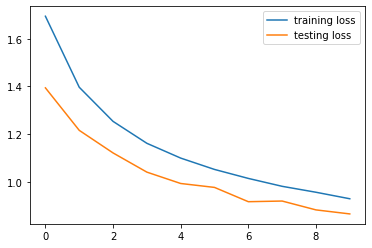

In [0]:
plt.plot(running_loss_hist, label = 'training loss')
plt.plot(test_running_loss_hist, label = 'testing loss')
plt.legend()

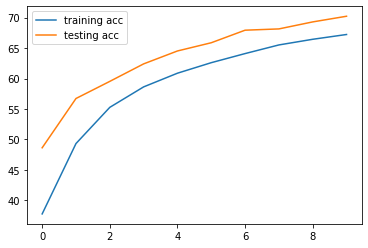

In [0]:
plt.plot(running_corrects_hist, label = 'training acc')
plt.plot(test_running_corrects_hist, label = 'testing acc')
plt.legend()

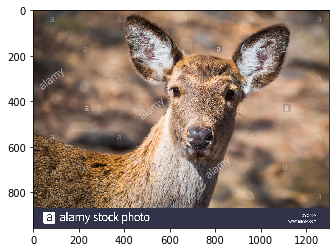

In [0]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
 
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

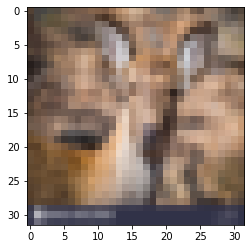

In [0]:
img = transform(img) 
plt.imshow(im_convert(img))

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


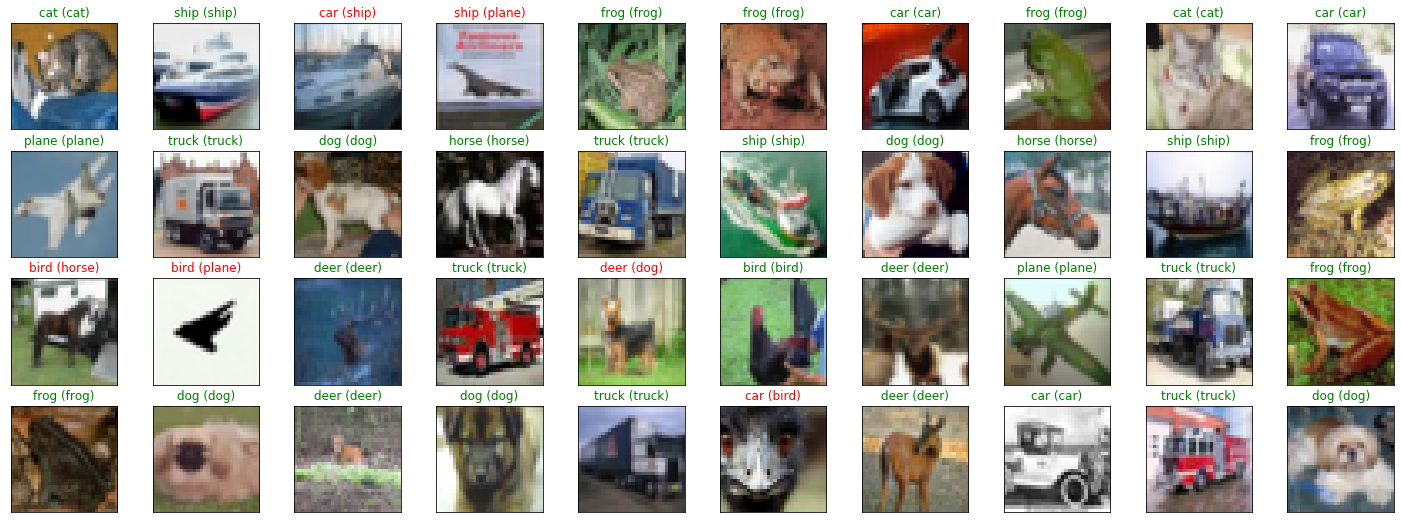

In [0]:
dataiter = iter(testing_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 9))
 
for idx in np.arange(40):
  ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))